In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve,
)
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier, plot_importance

In [2]:
df = pd.read_csv("../data/loan_cleaned.csv").sample(frac=1, random_state=123456).reset_index(drop=True)
columns = df.columns
float_columns = list(df.dtypes[df.dtypes == "float"].index) + ["emp_length", "grade"]

# normalise
df[float_columns] = (df[float_columns] - df[float_columns].mean())/df[float_columns].std()

# class weights
weight = df["loan_status"].sum()/df["loan_status"].count()

## Train-test split

Split the dataset into 80% training and 20% testing dataset. The training dataset is used to find the best fit weights of the logistic regression with the testing dataset left to evaluate the performance of the model.

In [3]:
X = df[[c for c in df.columns if c != "loan_status"]].values
y = df["loan_status"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123456,
)

## Logistic regression

In [4]:
logreg = LogisticRegression(
    C=1, class_weight={0: 1-weight, 1: weight}, max_iter=1000,
)
logreg.fit(X_train, y_train)

LogisticRegression(C=1,
                   class_weight={0: 0.7992697421589083, 1: 0.20073025784109172},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=1000, multi_class='auto',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [5]:
y_pred = logreg.predict(X_test)
display(
    f'recall    = {100*recall_score(y_test, y_pred):.1f}%',
    f'precision = {100*precision_score(y_test, y_pred):.1f}%',
    f'accuracy  = {100*accuracy_score(y_test, y_pred):.1f}%',
)

'recall    = 81.8%'

'precision = 99.0%'

'accuracy  = 96.2%'

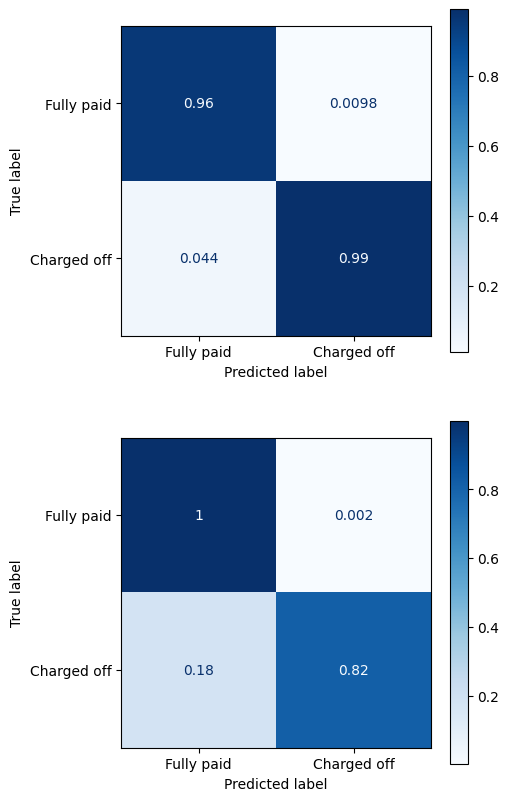

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(5, 10), dpi=100)
plot_confusion_matrix(
    logreg, X_test, y_test, display_labels=["Fully paid", "Charged off"],
    cmap=plt.cm.Blues, normalize='pred',
    ax=ax[0],
)
plot_confusion_matrix(
    logreg, X_test, y_test, display_labels=["Fully paid", "Charged off"],
    cmap=plt.cm.Blues, normalize='true',
    ax=ax[1],
)

## Boosted Decision Tree

In [7]:
bdt = XGBClassifier(scale_pos_weight=(1/weight) - 1.)
bdt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=3.9818099710291355, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [8]:
y_pred = bdt.predict(X_test)
display(
    f'recall    = {100*recall_score(y_test, y_pred):.1f}%',
    f'precision = {100*precision_score(y_test, y_pred):.1f}%',
    f'accuracy  = {100*accuracy_score(y_test, y_pred):.1f}%',
)

'recall    = 95.6%'

'precision = 97.8%'

'accuracy  = 98.7%'

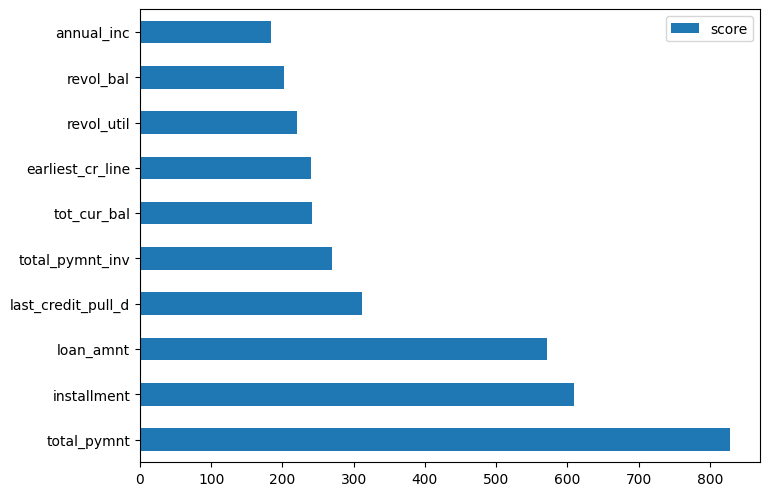

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
feature_importance = bdt.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

keys = [[c for c in df.columns if c != "loan_status"][int(k[1:])] for k in keys]
data = (
    pd.DataFrame(values, index=keys, columns=["score"])
    .sort_values(by="score", ascending=False)
)
data.iloc[:10].plot(kind='barh', ax=ax)

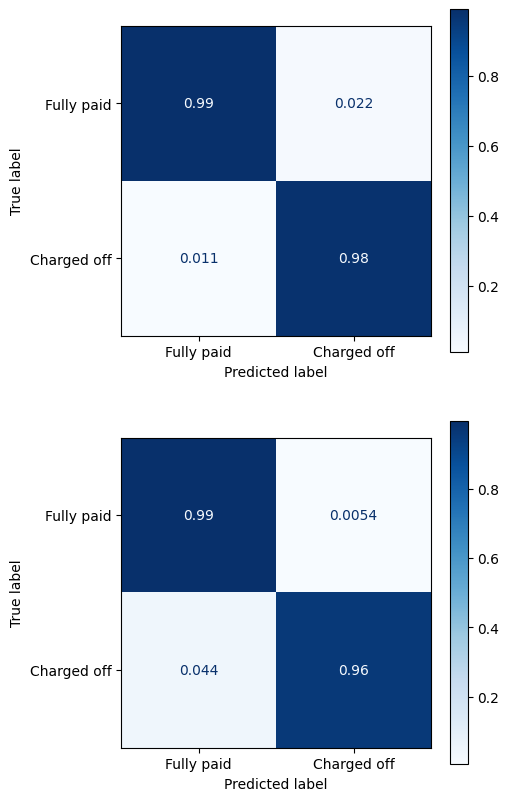

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(5, 10), dpi=100)
plot_confusion_matrix(
    bdt, X_test, y_test, display_labels=["Fully paid", "Charged off"],
    cmap=plt.cm.Blues, normalize='pred',
    ax=ax[0],
)
plot_confusion_matrix(
    bdt, X_test, y_test, display_labels=["Fully paid", "Charged off"],
    cmap=plt.cm.Blues, normalize='true',
    ax=ax[1],
)

## Model metrics

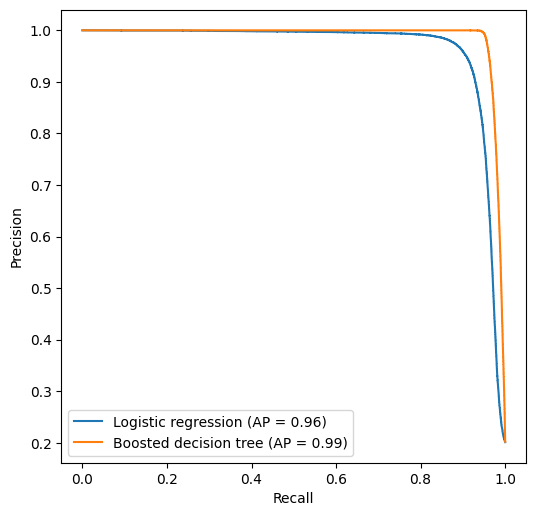

In [11]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
plot_precision_recall_curve(
    logreg, X_test, y_test, name="Logistic regression", ax=ax,
)
plot_precision_recall_curve(
    bdt, X_test, y_test, name="Boosted decision tree", ax=ax,
)

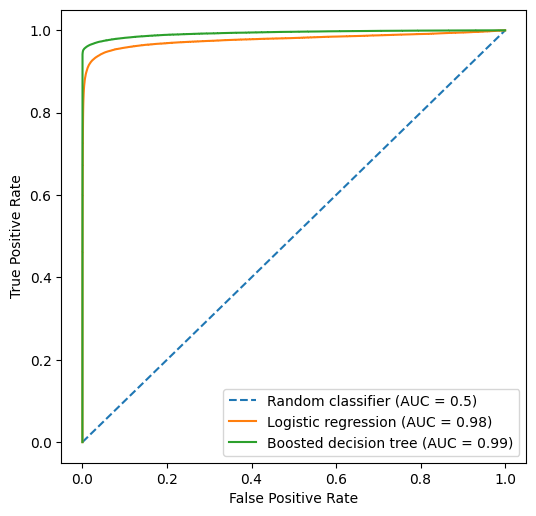

In [12]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.plot([0, 1], [0, 1], ls='--', label='Random classifier (AUC = 0.5)')
plot_roc_curve(logreg, X_test, y_test, name="Logistic regression", ax=ax)
plot_roc_curve(bdt, X_test, y_test, name="Boosted decision tree", ax=ax)

## Further Improvements

* Feature engineering:
    - Use joint account holder information: with a separate classifier or fill the joint account holder features for the single account holder with their metrics.
    - The absolute value of some dates may not mean much, instead relative dates are more relevant.
    - Try to remedy more features rather than dropping them.
    - Cluster states into fewer unique groups: e.g. east coast, central, west coast. Similarly for occupation.
* Probably can't get a much better model than the BDT in this case especially with a dataset of this size.
* More advancement cross validation technique (such a K-fold).
* Bayesian optimization of the hyperparameters.
    - Need to be careful with overtraining and introduce a third split
* When type-I and type-II errors become low, identify those events to understand why the classifier makes these errors.
* Search for outliers.